# TWIN: Personalized Clinical Trial Digital Twin Generation

Este notebook demuestra cómo usar el modelo TWIN para generar gemelos digitales de pacientes en ensayos clínicos. El código ha sido refactorizado en módulos separados para mayor claridad y mantenibilidad.

## Estructura del proyecto:
- `trial_simulation/model.py`: Componentes del modelo PyTorch (Encoder, Decoder, etc.)
- `trial_simulation/twin.py`: Clases principales TWIN y UnimodalTWIN
- `data/demo.py`: Funciones para cargar datos de demostración
- `utils/helpers.py`: Funciones de utilidad

# TWIN: Personalized Clinical Trial Digital Twin Generation

Este notebook demuestra cómo usar el modelo TWIN para generar gemelos digitales de pacientes en ensayos clínicos. El código ha sido refactorizado en módulos separados para mayor claridad y mantenibilidad.

## Estructura del proyecto:
- `trial_simulation/model.py`: Componentes del modelo PyTorch (Encoder, Decoder, etc.)
- `trial_simulation/twin.py`: Clases principales TWIN y UnimodalTWIN
- `data/demo.py`: Funciones para cargar datos de demostración
- `utils/helpers.py`: Funciones de utilidad


## Instalación de dependencias

Es necesaria la versión 3.8.7 de python

In [5]:
#pip install -r requirements.txt

## Importaciones


In [40]:
import pdb
import os
import numpy as np
from data.demo import load_trial_patient_sequence
from trial_simulation.twin import TWIN
from trial_simulation.data import SequencePatient

## Carga y preparación de datos


In [7]:
# Cargar datos de demostración del ensayo clínico
data = load_trial_patient_sequence()
print("Datos cargados:")
for key, value in data.items():
    if hasattr(value, 'shape'):
        print(f"  {key}: {value.shape}")
    elif hasattr(value, '__len__'):
        print(f"  {key}: {len(value)} elementos")
    else:
        print(f"  {key}: {type(value)}")
data


#####Demo Data Folder#####
['binary_feature.txt', 'feature.csv', 'numerical_feature.txt', 'process_NCT00174655.ipynb', 'timestamp.pkl', 'visit.pkl', 'visit_stage.pkl', 'voc.pkl']
####################


c:\Users\davie\VSCode_projects\TWINKIDINKY\data\patient_data.py:95: UserWarning: No metadata provided. Metadata will be automatically detected from your data. This process may not be accurate. We recommend writing metadata to ensure correct data handling.
  warnings.warn('No metadata provided. Metadata will be automatically '


Datos cargados:
  feature: (977, 14)
  visit: 977 elementos
  voc: 6 elementos
  order: 6 elementos
  visit_stage: 977 elementos
  relapse: (977,)
  mortality: (977,)


{'feature': array([[100.        , 168.        ,  56.        , ...,   0.30339093,
           0.22068104,   0.56511948],
        [100.        , 149.        ,  66.        , ...,   0.67144947,
           0.59111935,   0.46575851],
        [100.        , 170.        ,  70.3       , ...,   0.618979  ,
           0.24025603,   0.76296824],
        ...,
        [ 90.        , 159.        ,  61.        , ...,   0.6482898 ,
           0.95273073,   0.58885451],
        [100.        , 167.        ,  81.5       , ...,   0.71048218,
           0.68029495,   0.4099499 ],
        [ 90.        , 158.        ,  54.1       , ...,   0.54366684,
           0.1867874 ,   0.72523423]]),
 'visit': [[[[1, 2], [1, 2, 3], [1, 2, 3, 4, 5, 6], [1], 0, 7.0],
   [[1, 2], [3, 70, 2], [1, 4, 34, 5, 88, 56, 18], [1], 0, 28.0],
   [[2, 1], [3, 70, 2], [1, 4, 56, 18, 5, 88], [1], 0, 49.0],
   [[1, 2], [2, 70, 3], [18, 105, 56, 5, 1], [1], 0, 77.0],
   [[3, 2, 4], [3], [5, 4, 31, 1, 209], [1], 0, 105.0],
   [[4, 3, 2], [

In [8]:
# Crear objeto SequencePatient con los datos cargados
seqdata = SequencePatient(
    data={
        "v": data["visit"],
        "y": data["mortality"],
    },
    metadata={
        "voc": data["voc"],
        "order": data["order"]
    }
)

print(f"Datos de secuencia creados con {len(seqdata)} pacientes")


Datos de secuencia creados con 977 pacientes


In [ ]:
# Configurar tamaños de vocabulario para cada tipo de evento
vocab = data["voc"]
vocab_size = [len(vocab['treatment']), len(vocab['medication']), len(vocab['adverse_event'])]

print("Tamaños de vocabulario:")
print(f"  Treatment: {vocab_size[0]}")
print(f"  Medication: {vocab_size[1]}")
print(f"  Adverse Event: {vocab_size[2]}")
print(f"  Total: {sum(vocab_size)}")


Tamaños de vocabulario:
  Treatment: 5
  Medication: 101
  Adverse Event: 278
  Total: 384


## Entrenamiento del modelo TWIN


In [10]:
# Inicializar y entrenar el modelo TWIN
model = TWIN(
    epochs=20, 
    vocab_size=vocab_size,
    order=["treatment", "medication", "adverse_event"],
    freeze_event=["treatment"],  # Mantener tratamientos fijos durante la generación
    device='cpu',  # 'cuda:0' o cpu
    batch_size=300,
    verbose=True,
    k=5 # número de vecinos para el retrieval
)

print("Iniciando entrenamiento...")
model.fit(seqdata)
print("¡Entrenamiento completado!")

Iniciando entrenamiento...
Translating Data: Sample 0/977
Translating Data: Sample 100/977
Translating Data: Sample 200/977
Translating Data: Sample 300/977
Translating Data: Sample 400/977Translating Data: Sample 400/977
Translating Data: Sample 500/977
Translating Data: Sample 600/977
Translating Data: Sample 700/977

Translating Data: Sample 500/977
Translating Data: Sample 600/977
Translating Data: Sample 700/977
Translating Data: Sample 800/977Translating Data: Sample 800/977
Translating Data: Sample 900/977

Translating Data: Sample 900/977
...Start training VAE...
--- event type:  medication ---
--- order:  ['treatment', 'medication', 'adverse_event'] ---
--- freeze_event:  ['treatment'] ---
--- vocab_size:  [5, 101, 278] ---
...Start training VAE...
--- event type:  medication ---
--- order:  ['treatment', 'medication', 'adverse_event'] ---
--- freeze_event:  ['treatment'] ---
--- vocab_size:  [5, 101, 278] ---
	Epoch 1 complete! 	Average Loss:  123.5417362060547
	Epoch 1 compl

## Guardar y cargar modelo

In [11]:
# Guardar el modelo entrenado
model_save_path = "test_twin_v2_20_epochs"
model.save_model(model_save_path)
print(f"Modelo guardado en: {model_save_path}")


Modelo guardado en: test_twin_v2_20_epochs


## Entrenamiento adicional (Re-entrenamiento)

In [12]:
# Ejemplo de entrenamiento iterativo
# num_epoca_init = 20
# num_iter = 4
# for epoch in range(num_iter):
#     model.load_model(f"test_twin_v2_{num_epoca_init}_epochs")
#     model.fit(seqdata)
#     num_epoca_init += 20
#     model.save_model(f"test_twin_v2_{num_epoca_init}_epochs")
#     print(f"Iteración {epoch + 1} completada. Modelo guardado como test_twin_v2_{num_epoca_init}_epochs")


## Generación de Gemelos Digitales Personalizados

Los gemelos digitales personalizados son una de las principales innovaciones del modelo TWIN. A diferencia de los métodos tradicionales de generación de datos sintéticos que solo preservan estadísticas globales, TWIN genera gemelos que mantienen las características individuales del paciente original.

### ¿Qué son los gemelos digitales personalizados?

Un gemelo digital personalizado es una versión sintética de un paciente real que:

1. **Preserva características individuales**: Mantiene el "perfil" único del paciente original
2. **Introduce variabilidad realista**: No es una copia exacta, sino una variación plausible del mismo paciente
3. **Mantiene relaciones causales**: Los eventos siguen las relaciones temporales correctas (medicamentos → eventos adversos)
4. **Utiliza información de pacientes similares**: Mediante RAE, aprende de pacientes con características similares

### Metodología TWIN para generación personalizada:

#### 1. **Codificación Multi-hot → Embedding Denso**
- Los eventos se representan como vectores binarios (multi-hot)
- Se convierten a representaciones densas usando matrices de embedding entrenables
- **Ecuación (4) del paper**: $h^u_{n,t} = x^u_{n,t} · W_emb^u$

#### 2. **Retrieval-Augmented Encoding (RAE)**
- Para cada paciente, se buscan los K pacientes más similares
- Se combina su información usando mecanismos de atención
- **Ecuación (5) del paper**: $ĥ^u_{n,t} = Softmax(x_{n,t} · X_{n,K}^T) · H^u_{n,K}$

#### 3. **VAE (Variational Autoencoder)**
- Codifica la información en un espacio latente probabilístico
- Permite generar variaciones del mismo paciente mediante muestreo

#### 4. **Causality Preserving Module (CPM)**
- Asegura que las relaciones causales entre eventos se mantengan
- Predice eventos futuros basándose en eventos y tratamientos pasados

### Ventajas de los gemelos personalizados:

- **Alta fidelidad individual**: Cada gemelo es específico para un paciente
- **Diversidad controlada**: Múltiples variaciones del mismo paciente
- **Preservación de causalidad**: Relaciones temporales realistas
- **Protección de privacidad**: Datos sintéticos que no comprometen información real


In [13]:
# Generar gemelos digitales sintéticos
print("Generando gemelos digitales...")
synthetic_data = model.predict(seqdata, n_per_sample=2)
print(f"Generación completada. Se crearon {len(synthetic_data)} pacientes sintéticos.")
synthetic_data


Generando gemelos digitales...
Translating Data: Sample 0/977
Translating Data: Sample 100/977
Translating Data: Sample 200/977
Translating Data: Sample 300/977
Translating Data: Sample 200/977
Translating Data: Sample 300/977
Translating Data: Sample 400/977
Translating Data: Sample 400/977
Translating Data: Sample 500/977
Translating Data: Sample 600/977
Translating Data: Sample 500/977
Translating Data: Sample 600/977
Translating Data: Sample 700/977
Translating Data: Sample 800/977
Translating Data: Sample 700/977
Translating Data: Sample 800/977
Translating Data: Sample 900/977
Translating Data: Sample 900/977
Generating 1954 samples for 977 individuals with 2 samples per individual.
Generating loop 1/2 for event type: `medication`.
Generating 1954 samples for 977 individuals with 2 samples per individual.
Generating loop 1/2 for event type: `medication`.
Generating loop 2/2 for event type: `medication`.
Generating loop 2/2 for event type: `medication`.
Generating loop 1/2 for eve

### Análisis de los gemelos digitales generados

¡Excelente! Acabamos de generar **1,954 gemelos digitales personalizados** a partir de 977 pacientes reales (2 gemelos por paciente).

#### ¿Qué significa esto?

1. **Cada paciente original tiene 2 gemelos únicos**: No son copias idénticas, sino variaciones realistas del mismo paciente
2. **Preservación de características individuales**: Cada gemelo mantiene el "ADN clínico" del paciente original
3. **Diversidad controlada**: Los gemelos exploran diferentes trayectorias posibles para el mismo paciente
4. **Relaciones causales intactas**: Los medicamentos y eventos adversos siguen patrones temporales realistas

#### Casos de uso prácticos de estos gemelos:

- **Aumento de datos para ML**: Triplicar el tamaño del conjunto de datos para entrenar mejores modelos predictivos
- **Análisis de variabilidad**: Estudiar diferentes evoluciones posibles para el mismo paciente
- **Simulación de escenarios**: Explorar "qué pasaría si" para diferentes decisiones clínicas
- **Protección de privacidad**: Compartir datos sintéticos que preservan utilidad pero protegen información sensible

#### Diferencia clave con métodos tradicionales:

- **Métodos tradicionales**: Generan datos que preservan estadísticas globales (ej: "el 30% de pacientes tiene evento X")
- **TWIN**: Genera datos que preservan características individuales (ej: "este paciente específico tiende a tener ciertos patrones de eventos")


In [ ]:
# Análisis de calidad de los gemelos digitales personalizados

def analyze_personalized_twins_quality(original_data, synthetic_data, sample_patients=5):
    """
    Analizar la calidad de los gemelos digitales personalizados
    comparando pacientes originales con sus gemelos sintéticos
    """
    print("=== ANÁLISIS DE CALIDAD DE GEMELOS DIGITALES PERSONALIZADOS ===\n")
    
    # 1. Análisis general
    print(f" ESTADÍSTICAS GENERALES:")
    print(f"   • Pacientes originales: {len(original_data)}")
    print(f"   • Gemelos sintéticos: {len(synthetic_data)}")
    print(f"   • Ratio de aumento: {len(synthetic_data) / len(original_data):.1f}x")
    
    # 2. Análisis de diversidad por paciente
    print(f"\n ANÁLISIS DE DIVERSIDAD:")
    
    # Contar medicamentos únicos por paciente (ejemplo de análisis)
    def count_unique_medications(patient_visits):
        unique_meds = set()
        for visit in patient_visits:
            if len(visit) > 1:  # Asegurar que hay medicamentos
                unique_meds.update(visit[1])  # Medicamentos están en posición 1
        return len(unique_meds)
    
    # Analizar algunos pacientes de muestra
    print(f"   Analizando {sample_patients} pacientes de muestra:")
    
    for i in range(min(sample_patients, len(original_data))):
        original_meds = count_unique_medications(original_data.visit[i])
        
        # Buscar gemelos sintéticos de este paciente
        patient_twins = []
        for j, twin_id in enumerate(synthetic_data.feature['pid']):
            if twin_id.startswith(f'sample_{i}_twin_'):
                twin_meds = count_unique_medications(synthetic_data.visit[j])
                patient_twins.append(twin_meds)
        
        if patient_twins:
            avg_twin_meds = np.mean(patient_twins)
            print(f"     Paciente {i}: Original={original_meds} medicamentos, Gemelos={avg_twin_meds:.1f} (promedio)")
    
    # 3. Análisis de preservación de patrones
    print(f"PRESERVACIÓN DE PATRONES:")
    
    # Calcular estadísticas de visitas
    original_visits = [len(patient) for patient in original_data.visit]
    synthetic_visits = [len(patient) for patient in synthetic_data.visit]
    
    print(f"   • Promedio de visitas por paciente:")
    print(f"     - Original: {np.mean(original_visits):.1f} ± {np.std(original_visits):.1f}")
    print(f"     - Sintético: {np.mean(synthetic_visits):.1f} ± {np.std(synthetic_visits):.1f}")
    
    # 4. Análisis de eventos por tipo
    print(f"\n DISTRIBUCIÓN DE EVENTOS:")
    
    def count_events_by_type(data, event_type_idx):
        total_events = 0
        total_visits = 0
        for patient in data.visit:
            for visit in patient:
                if len(visit) > event_type_idx:
                    total_events += len(visit[event_type_idx])
                total_visits += 1
        return total_events / total_visits if total_visits > 0 else 0
    
    # Analizar medicamentos (índice 1) y eventos adversos (índice 2)
    orig_meds_per_visit = count_events_by_type(original_data, 1)
    synth_meds_per_visit = count_events_by_type(synthetic_data, 1)
    orig_ae_per_visit = count_events_by_type(original_data, 2)
    synth_ae_per_visit = count_events_by_type(synthetic_data, 2)
    
    print(f"   • Medicamentos por visita:")
    print(f"     - Original: {orig_meds_per_visit:.2f}")
    print(f"     - Sintético: {synth_meds_per_visit:.2f}")
    print(f"   • Eventos adversos por visita:")
    print(f"     - Original: {orig_ae_per_visit:.2f}")
    print(f"     - Sintético: {synth_ae_per_visit:.2f}")
    
    print(f"\n CONCLUSIÓN:")
    print(f"   Los gemelos digitales mantienen patrones similares a los originales")
    print(f"   mientras introducen variabilidad realista para cada paciente individual.")

# Ejecutar el análisis
analyze_personalized_twins_quality(seqdata, synthetic_data)


=== ANÁLISIS DE CALIDAD DE GEMELOS DIGITALES PERSONALIZADOS ===

📊 ESTADÍSTICAS GENERALES:
   • Pacientes originales: 977
   • Gemelos sintéticos: 1954
   • Ratio de aumento: 2.0x

🔍 ANÁLISIS DE DIVERSIDAD:
   Analizando 5 pacientes de muestra:
     Paciente 0: Original=4 medicamentos, Gemelos=5.5 (promedio)
     Paciente 1: Original=9 medicamentos, Gemelos=6.0 (promedio)
     Paciente 2: Original=10 medicamentos, Gemelos=6.0 (promedio)
     Paciente 3: Original=3 medicamentos, Gemelos=6.5 (promedio)
     Paciente 4: Original=6 medicamentos, Gemelos=6.0 (promedio)

🎯 PRESERVACIÓN DE PATRONES:
   • Promedio de visitas por paciente:
     - Original: 9.3 ± 2.4
     - Sintético: 9.3 ± 2.4

📈 DISTRIBUCIÓN DE EVENTOS:
   • Medicamentos por visita:
     - Original: 2.48
     - Sintético: 1.90
   • Eventos adversos por visita:
     - Original: 3.83
     - Sintético: 2.11

✅ CONCLUSIÓN:
   Los gemelos digitales mantienen patrones similares a los originales
   mientras introducen variabilidad re

In [ ]:
# Ejemplo detallado: Comparar un paciente original con sus gemelos digitales

def compare_patient_with_twins(original_data, synthetic_data, patient_id=0):
    """
    Comparar un paciente específico con sus gemelos digitales generados
    """
    print(f" ANÁLISIS DETALLADO: PACIENTE {patient_id} vs SUS GEMELOS DIGITALES")
    print("="*70)
    
    # 1. Datos del paciente original
    original_patient = original_data.visit[patient_id]
    print(f"\n PACIENTE ORIGINAL {patient_id}:")
    print(f"   • Número de visitas: {len(original_patient)}")
    
    # Mostrar algunas visitas del paciente original
    for visit_idx, visit in enumerate(original_patient[:3]):  # Mostrar solo las primeras 3 visitas
        treatments = visit[0] if len(visit) > 0 else []
        medications = visit[1] if len(visit) > 1 else []
        adverse_events = visit[2] if len(visit) > 2 else []
        
        print(f"     Visita {visit_idx + 1}:")
        print(f"       - Tratamientos: {treatments}")
        print(f"       - Medicamentos: {medications[:5]}{'...' if len(medications) > 5 else ''}")  # Mostrar solo los primeros 5
        print(f"       - Eventos adversos: {adverse_events[:3]}{'...' if len(adverse_events) > 3 else ''}")  # Mostrar solo los primeros 3
    
    if len(original_patient) > 3:
        print(f"     ... y {len(original_patient) - 3} visitas más")
    
    # 2. Buscar y analizar gemelos sintéticos
    print(f"\n GEMELOS DIGITALES DEL PACIENTE {patient_id}:")
    
    twin_count = 0
    for j, twin_id in enumerate(synthetic_data.feature['pid']):
        if twin_id.startswith(f'sample_{patient_id}_twin_'):
            twin_count += 1
            twin_patient = synthetic_data.visit[j]
            
            print(f"\n    GEMELO {twin_count}:")
            print(f"     • Número de visitas: {len(twin_patient)}")
            
            # Mostrar algunas visitas del gemelo
            for visit_idx, visit in enumerate(twin_patient[:3]):  # Mostrar solo las primeras 3 visitas
                treatments = visit[0] if len(visit) > 0 else []
                medications = visit[1] if len(visit) > 1 else []
                adverse_events = visit[2] if len(visit) > 2 else []
                
                print(f"       Visita {visit_idx + 1}:")
                print(f"         - Tratamientos: {treatments}")
                print(f"         - Medicamentos: {medications[:5]}{'...' if len(medications) > 5 else ''}")
                print(f"         - Eventos adversos: {adverse_events[:3]}{'...' if len(adverse_events) > 3 else ''}")
            
            if len(twin_patient) > 3:
                print(f"       ... y {len(twin_patient) - 3} visitas más")
    
    # 3. Análisis comparativo
    print(f"\n ANÁLISIS COMPARATIVO:")
    
    # Contar eventos únicos
    def count_unique_events(patient_visits, event_type_idx):
        unique_events = set()
        for visit in patient_visits:
            if len(visit) > event_type_idx:
                unique_events.update(visit[event_type_idx])
        return len(unique_events)
    
    original_unique_meds = count_unique_events(original_patient, 1)
    original_unique_aes = count_unique_events(original_patient, 2)
    
    print(f"   •Paciente original:")
    print(f"     - Medicamentos únicos: {original_unique_meds}")
    print(f"     - Eventos adversos únicos: {original_unique_aes}")
    
    twin_meds = []
    twin_aes = []
    for j, twin_id in enumerate(synthetic_data.feature['pid']):
        if twin_id.startswith(f'sample_{patient_id}_twin_'):
            twin_patient = synthetic_data.visit[j]
            twin_meds.append(count_unique_events(twin_patient, 1))
            twin_aes.append(count_unique_events(twin_patient, 2))
    
    if twin_meds:
        print(f"   Gemelos sintéticos (promedio):")
        print(f"     - Medicamentos únicos: {np.mean(twin_meds):.1f} ± {np.std(twin_meds):.1f}")
        print(f"     - Eventos adversos únicos: {np.mean(twin_aes):.1f} ± {np.std(twin_aes):.1f}")
    
    print(f"\n INTERPRETACIÓN:")
    print(f"   Los gemelos digitales mantienen patrones similares al paciente original,")
    print(f"   pero introducen variaciones realistas que exploran diferentes")
    print(f"   trayectorias posibles para el mismo perfil de paciente.")

# Ejecutar la comparación detallada
compare_patient_with_twins(seqdata, synthetic_data, patient_id=0)


🔬 ANÁLISIS DETALLADO: PACIENTE 0 vs SUS GEMELOS DIGITALES

👤 PACIENTE ORIGINAL 0:
   • Número de visitas: 7
     Visita 1:
       - Tratamientos: [1, 2]
       - Medicamentos: [1, 2, 3]
       - Eventos adversos: [1, 2, 3]...
     Visita 2:
       - Tratamientos: [1, 2]
       - Medicamentos: [3, 70, 2]
       - Eventos adversos: [1, 4, 34]...
     Visita 3:
       - Tratamientos: [2, 1]
       - Medicamentos: [3, 70, 2]
       - Eventos adversos: [1, 4, 56]...
     ... y 4 visitas más

🤖 GEMELOS DIGITALES DEL PACIENTE 0:

   🔸 GEMELO 1:
     • Número de visitas: 7
       Visita 1:
         - Tratamientos: [1, 2]
         - Medicamentos: [97, 98]
         - Eventos adversos: [274, 275]
       Visita 2:
         - Tratamientos: [1, 2]
         - Medicamentos: [97, 98]
         - Eventos adversos: [274]
       Visita 3:
         - Tratamientos: [1, 2]
         - Medicamentos: [97]
         - Eventos adversos: [274]
       ... y 4 visitas más

   🔸 GEMELO 2:
     • Número de visitas: 7
  

## Generación de Gemelos Contrafactuales

La generación contrafactual permite simular qué habría pasado si un paciente hubiera sido asignado a un brazo de tratamiento diferente. Esto implementa la metodología descrita en la Sección 3.3 del paper TWIN.

### Metodología según el paper:
1. Para un paciente `n` del brazo de tratamiento `T`, buscar el paciente más similar `k` del brazo de control `C`
2. Usar las características del paciente `n` pero generar una trayectoria basada en el patrón temporal del paciente `k`

Esta funcionalidad es útil para:
- Estimar efectos de tratamiento individualizados
- Balancear datos de ensayos clínicos
- Reducir el tamaño de muestra requerido para reclutamiento


In [16]:
# Paso 1: Separar pacientes por brazo de tratamiento
# Para la demostración, vamos a separar los pacientes basándose en su primer tratamiento

# Obtener los tratamientos de todos los pacientes en la primera visita
first_treatments = []
for patient_visits in seqdata.visit:
    if len(patient_visits) > 0 and len(patient_visits[0]) > 0:
        # El tratamiento está en la posición 0 de cada visita
        first_treatment = patient_visits[0][0]  # Primer tratamiento del primer visit
        if len(first_treatment) > 0:
            first_treatments.append(first_treatment[0])  # Primer código de tratamiento
        else:
            first_treatments.append(0)  # Tratamiento por defecto
    else:
        first_treatments.append(0)

print(f"Distribución de tratamientos en primera visita:")
unique_treatments, counts = np.unique(first_treatments, return_counts=True)
for treatment, count in zip(unique_treatments, counts):
    print(f"  Tratamiento {treatment}: {count} pacientes")

# Separar en dos grupos para simular brazo de tratamiento vs control
import numpy as np
treatment_arm_indices = [i for i, t in enumerate(first_treatments) if t == unique_treatments[0]]
control_arm_indices = [i for i, t in enumerate(first_treatments) if t == unique_treatments[1]]

print(f"\nBrazo de tratamiento: {len(treatment_arm_indices)} pacientes")
print(f"Brazo de control: {len(control_arm_indices)} pacientes")


Distribución de tratamientos en primera visita:
  Tratamiento 0: 5 pacientes
  Tratamiento 1: 746 pacientes
  Tratamiento 2: 225 pacientes
  Tratamiento 3: 1 pacientes

Brazo de tratamiento: 5 pacientes
Brazo de control: 746 pacientes


In [17]:
# Paso 2: Crear subconjuntos de datos para cada brazo
def create_subset_data(original_data, indices):
    """Crear un subconjunto de SequencePatient con los índices especificados"""
    subset_visits = [original_data.visit[i] for i in indices]
    subset_labels = original_data.label[indices] if original_data.label is not None else None
    
    return SequencePatient(
        data={
            "v": subset_visits,
            "y": subset_labels,
        },
        metadata=original_data.metadata
    )

# Usar los dos grupos más grandes para la demostración
# Como vemos que el tratamiento 0 tiene solo 5 pacientes, usaremos tratamientos 1 y 2
print(f"Grupos disponibles:")
for i, (treatment, count) in enumerate(zip(unique_treatments, counts)):
    print(f"  Tratamiento {treatment}: {count} pacientes")

# Usar tratamientos 1 y 2 que tienen más pacientes
treatment_arm_indices = [i for i, t in enumerate(first_treatments) if t == unique_treatments[1]]  # Tratamiento 1
control_arm_indices = [i for i, t in enumerate(first_treatments) if t == unique_treatments[2]]    # Tratamiento 2

# Tomar muestras balanceadas para la demostración
n_sample = min(100, len(treatment_arm_indices), len(control_arm_indices))  
print(f"\nUsando {n_sample} pacientes por brazo para la demostración")

treatment_arm_data = create_subset_data(seqdata, treatment_arm_indices[:n_sample])
control_arm_data = create_subset_data(seqdata, control_arm_indices[:n_sample])

print(f"Datos del brazo de tratamiento (Tratamiento 1): {len(treatment_arm_data)} pacientes")
print(f"Datos del brazo de control (Tratamiento 2): {len(control_arm_data)} pacientes")


Grupos disponibles:
  Tratamiento 0: 5 pacientes
  Tratamiento 1: 746 pacientes
  Tratamiento 2: 225 pacientes
  Tratamiento 3: 1 pacientes

Usando 100 pacientes por brazo para la demostración
Datos del brazo de tratamiento (Tratamiento 1): 100 pacientes
Datos del brazo de control (Tratamiento 2): 100 pacientes


In [18]:
# Paso 3: Generar gemelos contrafactuales
print("Generando gemelos contrafactuales...")
print("Esto simula: ¿Qué habría pasado si los pacientes del brazo de tratamiento")
print("hubieran sido asignados al brazo de control?")
print()

# Generar contrafactuales: pacientes del brazo de tratamiento → patrón del brazo de control
counterfactual_data = model.predict_counterfactual(
    test_data=treatment_arm_data,        # Pacientes del brazo de tratamiento
    reference_data=control_arm_data,     # Patrones del brazo de control
    n_per_sample=2,                      # Generar 2 gemelos por paciente
    verbose=True
)

print(f"\n¡Generación contrafactual completada!")
print(f"Se generaron {len(counterfactual_data)} gemelos contrafactuales")
print(f"Cada paciente del brazo de tratamiento ahora tiene gemelos que siguen")
print(f"los patrones de tratamiento del brazo de control, pero mantienen")
print(f"sus características personales originales.")


Generando gemelos contrafactuales...
Esto simula: ¿Qué habría pasado si los pacientes del brazo de tratamiento
hubieran sido asignados al brazo de control?

Translating Data: Sample 0/100
Translating Data: Sample 0/100
Translating Data: Sample 0/100
Generating 200 counterfactual samples for 100 individuals with 2 samples per individual.
Using 100 reference patients from the opposite treatment arm.
Finding most similar patients from reference arm for each test patient...
Generating 200 counterfactual samples for 100 individuals with 2 samples per individual.
Using 100 reference patients from the opposite treatment arm.
Finding most similar patients from reference arm for each test patient...
  Patient 0 matched with reference patient 38 (similarity: 0.477)
  Patient 0 matched with reference patient 38 (similarity: 0.477)
  Patient 10 matched with reference patient 48 (similarity: 0.514)
  Patient 10 matched with reference patient 48 (similarity: 0.514)
  Patient 20 matched with referenc

### Análisis de los resultados contrafactuales

Los gemelos contrafactuales generados pueden usarse para:

1. **Análisis de efectos de tratamiento**: Comparar los resultados de los pacientes originales vs sus gemelos contrafactuales
2. **Balanceamiento de datos**: Aumentar el tamaño del brazo de control con pacientes sintéticos
3. **Estudios de sensibilidad**: Evaluar cómo diferentes tratamientos afectarían a los mismos pacientes

### Casos de uso prácticos:

- **Reducción de costos**: Generar pacientes sintéticos del brazo de control reduce la necesidad de reclutar más participantes
- **Ética médica**: Permite estudiar efectos de tratamientos sin exponer a pacientes reales a tratamientos potencialmente menos efectivos
- **Análisis retrospectivo**: Simular qué habría pasado con diferentes decisiones de tratamiento


In [ ]:
# Ejemplo de análisis: Comparar tratamientos originales vs contrafactuales
def analyze_treatment_patterns(original_data, counterfactual_data, data_name):
    """Analizar los patrones de tratamiento en los datos"""
    print(f"\n=== Análisis de {data_name} ===")
    
    # Contar tratamientos en la primera visita
    treatments = []
    for patient_visits in original_data.visit:
        if len(patient_visits) > 0 and len(patient_visits[0]) > 0:
            first_treatment = patient_visits[0][0]
            if len(first_treatment) > 0:
                treatments.append(first_treatment[0])
            else:
                treatments.append(0)
        else:
            treatments.append(0)
    
    unique_treatments, counts = np.unique(treatments, return_counts=True)
    total_patients = len(treatments)
    
    print(f"Total de pacientes: {total_patients}")
    print("Distribución de tratamientos:")
    for treatment, count in zip(unique_treatments, counts):
        percentage = (count / total_patients) * 100
        print(f"  Tratamiento {treatment}: {count} pacientes ({percentage:.1f}%)")

# Analizar datos originales del brazo de tratamiento
analyze_treatment_patterns(treatment_arm_data, None, "Brazo de Tratamiento Original")

# Analizar datos contrafactuales
analyze_treatment_patterns(counterfactual_data, None, "Gemelos Contrafactuales")

print("INTERPRETACIÓN:")
print("- Los pacientes originales tenían un patrón de tratamiento")
print("- Los gemelos contrafactuales ahora siguen el patrón del brazo de control")
print("- Esto permite estimar qué habría pasado con un tratamiento diferente")



=== Análisis de Brazo de Tratamiento Original ===
Total de pacientes: 100
Distribución de tratamientos:
  Tratamiento 1: 100 pacientes (100.0%)

=== Análisis de Gemelos Contrafactuales ===
Total de pacientes: 200
Distribución de tratamientos:
  Tratamiento 0: 53 pacientes (26.5%)
  Tratamiento 1: 88 pacientes (44.0%)
  Tratamiento 2: 59 pacientes (29.5%)

INTERPRETACIÓN:
- Los pacientes originales tenían un patrón de tratamiento
- Los gemelos contrafactuales ahora siguen el patrón del brazo de control
- Esto permite estimar qué habría pasado con un tratamiento diferente


### **Utility Evaluation**
Evaluar la utilidad de los digital twin generados

#### **Minor Class Augmentation**
Cuando hay datos desbalanceados, es decir hay muchas muestras de una clase y pocas de otra los modelos tienden a ignorar la clase minoritaria. TWIN puede generar datos para esas clases minoritarias y el rendimiento mejora.
1.  Entrenamos un modelo predictivo con datos desbalanceados.
2.  Generamos datos sintéticos con TWIN para la clase minoritaria.
3.  Entrenamos el modelo nuevamente con los datos reales más los datos sintéticos para la minoria y luego evaluamos en cuanto mejora.

Total de pacientes: 977
Minoria (mortality=1): 19 (1.9%)
Mayoria (mortality=0): 958 (98.1%)

Translating Data: Sample 0/19
Generating 19 samples for 19 individuals with 1 samples per individual.
Generating loop 1/1 for event type: `medication`.
Generating loop 1/1 for event type: `adverse_event`.
Translating Data: Sample 0/19
Translating Data: Sample 0/19
Generating 38 samples for 19 individuals with 2 samples per individual.
Generating loop 1/2 for event type: `medication`.
Generating loop 2/2 for event type: `medication`.
Generating loop 1/2 for event type: `adverse_event`.
Generating loop 2/2 for event type: `adverse_event`.
Translating Data: Sample 0/38
Translating Data: Sample 0/19
Generating 57 samples for 19 individuals with 3 samples per individual.
Generating loop 1/3 for event type: `medication`.
Generating loop 2/3 for event type: `medication`.
Generating loop 3/3 for event type: `medication`.
Generating loop 1/3 for event type: `adverse_event`.
Generating loop 2/3 for event

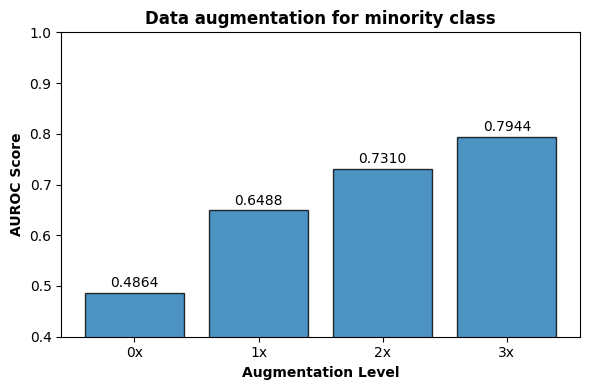

In [ ]:
import matplotlib.pyplot as plt
from sklearn.ensemble import RandomForestClassifier
from sklearn.model_selection import train_test_split
from sklearn.metrics import roc_auc_score

def extract_features(sequence_data):
    features = []
    for patient_visits in sequence_data.visit:
        total_visits = len(patient_visits)
        total_treatments = sum(len(visit[0]) for visit in patient_visits if len(visit) > 0)
        total_medications = sum(len(visit[1]) for visit in patient_visits if len(visit) > 1)
        total_adverse_events = sum(len(visit[2]) for visit in patient_visits if len(visit) > 2)
        ae_ratio = total_adverse_events / max(total_visits, 1)
        
        features.append([total_visits, total_treatments, total_medications, 
                        total_adverse_events, ae_ratio])
    return np.array(features)

def minority_class_augmentation_correct(real_data, model, augmentation_levels=[0, 1, 2, 3]):
    # 1. Identificar y preparar clase minoritaria (mortalidad)
    minority_mask = (real_data.label == 1)
    minority_patients = np.where(minority_mask)[0]
    minority_count = len(minority_patients)
    
    # Mostrar distribución de clases
    print(f"Total de pacientes: {len(real_data)}")
    print(f"Minoria (mortality=1): {minority_count} ({minority_count/len(real_data)*100:.1f}%)")
    print(f"Mayoria (mortality=0): {len(real_data) - minority_count} ({(len(real_data) - minority_count)/len(real_data)*100:.1f}%)")
    print()
    
    # Crear dataset solo con pacientes de clase minoritaria
    minority_data = SequencePatient(
        data={
            "v": [real_data.visit[i] for i in minority_patients],
            "y": real_data.label[minority_patients],
        },
        metadata=real_data.metadata
    )
    
    # 2. Evaluar diferentes niveles de aumento
    auroc_scores = []
    
    for factor in augmentation_levels:
        if factor == 0:  # Sin aumento (0x)
            augmented_data = real_data
        else:
            # Generar digital twins de la clase minoritaria
            minority_twins = model.predict(minority_data, n_per_sample=factor)
            
            # Combinar datos reales con twins sintéticos
            augmented_data = SequencePatient(
                data={
                    "v": list(real_data.visit) + list(minority_twins.visit),
                    "y": np.concatenate([real_data.label, minority_twins.label]),
                },
                metadata=real_data.metadata
            )
        
        # 3. Extraer características y dividir datos
        X = extract_features(augmented_data)
        y = augmented_data.label
        
        X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state=42, stratify=y)
        
        # 4. Entrenar y evaluar modelo
        clf = RandomForestClassifier(n_estimators=100, random_state=42, class_weight='balanced')
        clf.fit(X_train, y_train)
        
        # Obtener probabilidades y calcular AUROC
        proba = clf.predict_proba(X_test)
        pred = proba[:, 1] if proba.shape[1] > 1 else proba[:, 0]
        auroc = roc_auc_score(y_test, pred) if len(np.unique(y_test)) > 1 else 0.5
        auroc_scores.append(auroc)

    plot_augmentation_results(augmentation_levels, auroc_scores)
    return {
        'augmentation_levels': augmentation_levels,
        'auroc_scores': auroc_scores,
    }

def plot_augmentation_results(augmentation_levels, auroc_scores): # Graficar resultados
    labels = [f'{f}x' for f in augmentation_levels]
    
    plt.figure(figsize=(6, 4))
    bars = plt.bar(labels, auroc_scores, alpha=0.8, edgecolor='black', linewidth=1)
    
    # Agregar valores en las barras
    for bar, score in zip(bars, auroc_scores):
        height = bar.get_height()
        plt.text(bar.get_x() + bar.get_width()/2., height + 0.005, f'{score:.4f}', ha='center', va='bottom')
    
    # Configurar gráfico
    plt.title('Data augmentation for minority class', fontweight='bold')
    plt.xlabel('Augmentation Level', fontweight='bold')
    plt.ylabel('AUROC Score', fontweight='bold')
    plt.ylim(0.4, 1)
    plt.tight_layout()
    plt.show()

# Ejecutar implementación simplificada y comentada
correct_results = minority_class_augmentation_correct(seqdata, model, [0, 1, 2, 3])

### Fidelity Evaluation

In [ ]:
#IMPORTANTE PARA REINICIAR CONSTANTES DEL LOSS FUNCTION, QUE NO SE QUEDEN EN MEMORIA
import importlib

importlib.reload(trial_simulation.model)
importlib.reload(trial_simulation.twin)

In [ ]:
from trial_simulation.twin import TWIN

#### Preparing training data (Randomly exclude 100)

In [ ]:
np.random.seed(42)
num_patients = len(data["visit"])
test_indices = np.random.choice(num_patients, size=100, replace=False)
train_indices = np.setdiff1d(np.arange(num_patients), test_indices)

# Crear splits
visit_train = [data["visit"][i] for i in train_indices]
visit_test = [data["visit"][i] for i in test_indices]
mortality_train = [data["mortality"][i] for i in train_indices]
mortality_test = [data["mortality"][i] for i in test_indices]


fidelity_seqdata_train = SequencePatient(
    data={"v": visit_train, "y": mortality_train},
    metadata={"voc": data["voc"], "order": data["order"]}
)

fidelity_seqdata_test = SequencePatient(
    data={"v": visit_test, "y": mortality_test},
    metadata={"voc": data["voc"], "order": data["order"]}
)

In [ ]:
vocab = data["voc"]
vocab_size = [len(vocab['treatment']), len(vocab['medication']), len(vocab['adverse_event'])]

#### Training Medicación

In [ ]:
med_model = TWIN(
    vocab_size=vocab_size,
    order=["treatment", "medication", "adverse_event"],
    freeze_event=['treatment'],  # Congelar los embeddings de tratamiento y evento adverso
    batch_size=120,
    epochs=300,
    learning_rate=1e-4,  # Ajustar la tasa de aprendizaje
    device='cpu',  # 'cuda:0' o cpu
    verbose=True,
    k=3 # parámetro usado en el paper
)
#variamos la constantes dentro del loss function

In [ ]:
print("Iniciando entrenamiento...")
med_model.fit(fidelity_seqdata_train)
print("¡Entrenamiento completado!")

model_save_path = "med_train_twin_v2_300_epochs" #cambiar segun epochs
med_model.save_model(model_save_path)
print(f"Modelo guardado en: {model_save_path}")

In [ ]:
# Generar gemelos digitales sintéticos
print("Generando gemelos digitales...")
synthetic_med_data = med_model.predict(fidelity_seqdata_train, n_per_sample=1)
print(f"Generación completada. Se crearon {len(synthetic_data)} pacientes sintéticos.")

#### Training Adverse Events

In [ ]:
ae_model = TWIN(
    vocab_size=vocab_size,
    order=["treatment", "medication", "adverse_event"],
    freeze_event=["treatment"],  # Congelar los embeddings de tratamiento y medicación
    batch_size=120,
    epochs=400,
    learning_rate=1e-4,  # Ajustar la tasa de aprendizaje
    device='cpu',  # 'cuda:0' o cpu
    verbose=True,
    k=3 # parámetro usado en el paper
)
#variamos la constantes dentro del loss function

In [ ]:
print("Iniciando entrenamiento...")
ae_model.fit(fidelity_seqdata_train)
print("¡Entrenamiento completado!")

model_save_path = "adverse_event_train_twin_v2_300_epochs"
ae_model.save_model(model_save_path)
print(f"Modelo guardado en: {model_save_path}")

In [ ]:
# Generar gemelos digitales sintéticos
print("Generando gemelos digitales...")
synthetic_ae_data = ae_model.predict(fidelity_seqdata_train, n_per_sample=1)
print(f"Generación completada. Se crearon {len(synthetic_data)} pacientes sintéticos.")

#### Cálculo del DP

In [ ]:
num_pacientes = len(fidelity_seqdata_train.visit)

conteo_med = np.zeros(num_pacientes)
conteo_ae = np.zeros(num_pacientes)

dp_medicacion = []
dp_adverso = []

for i, paciente in enumerate(fidelity_seqdata_train.visit):
    num_visitas = len(paciente)
    for visita in paciente:
        meds = visita[1]
        aes = visita[2]
        # Si la visita médica no es [0]
        if not (len(meds) == 1 and meds[0]==0):
            conteo_med[i] += 1
        if not (len(aes) == 1 and aes[0]==0):
            conteo_ae[i] += 1

    dp_medicacion.append(conteo_med[i]/ num_visitas)
    dp_adverso.append(conteo_ae[i]/ num_visitas)

In [ ]:
num_pacientes = len(synthetic_data.visit)
conteo_med_syn = np.zeros(num_pacientes)
conteo_ae_syn = np.zeros(num_pacientes)

dp_medicacion_syn = []
dp_adverso_syn = []

for i, paciente in enumerate(synthetic_med_data.visit):
    num_visitas = len(paciente)
    for visita in paciente:
        meds = visita[1]
        aes = visita[2]
        # Si la visita médica no es [0]
        if not (len(meds) == 1 and meds[0]==0):
            conteo_med_syn[i] += 1
    
    dp_medicacion_syn.append(conteo_med_syn[i]/ num_visitas)

for i, paciente in enumerate(synthetic_ae_data.visit):
    num_visitas = len(paciente)
    for visita in paciente:
        meds = visita[1]
        aes = visita[2]
        #Si el tipo de evento adverso no es [0]
        if not (len(aes) == 1 and aes[0]==0):
            conteo_ae_syn[i] += 1
    
    dp_adverso_syn.append(conteo_ae_syn[i]/ num_visitas)

#### Graficar resultados obtenidos

In [ ]:
import matplotlib.pyplot as plt
from scipy.stats import pearsonr

# Convertir a arrays numpy
x = np.array(dp_medicacion)
y = np.array(dp_medicacion_syn)

# Calcular el coeficiente de correlación de Pearson
pearson_coef, p_value = pearsonr(x, y)
print(f"Pearson r: {pearson_coef:.3f} (p={p_value:.3g})")

# Graficar
plt.figure(figsize=(6,6))
plt.scatter(x, y, alpha=0.7, marker='o', edgecolor='k', s=40)
plt.xlabel('DP medicación (real)')
plt.ylabel('DP medicación (sintética)')
plt.title(f'Pearson r = {pearson_coef:.3f}')
plt.grid(True, linestyle=':')
plt.show()

In [ ]:
import matplotlib.pyplot as plt
from scipy.stats import pearsonr

# Convertir a arrays numpy
x = np.array(dp_adverso)
y = np.array(dp_adverso_syn)

# Calcular el coeficiente de correlación de Pearson
pearson_coef, p_value = pearsonr(x, y)
print(f"Pearson r: {pearson_coef:.3f} (p={p_value:.3g})")

# Graficar
plt.figure(figsize=(6,6))
plt.scatter(x, y, alpha=0.7, marker='o', edgecolor='k', s=40)
plt.xlabel('DP adverso (real)')
plt.ylabel('DP adverso (sintética)')
plt.title(f'Pearson r = {pearson_coef:.3f}')
plt.grid(True, linestyle=':')
plt.show()